In [2]:
import pandas as pd
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.gaussian_process import GaussianProcess
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

In [3]:
n = 30 
N = int(n**2) ## sample size
M = 1 ## Number of replicate
coord1 = np.linspace(0,1,n)
coord2 = np.linspace(0,1,n)
P = 1
X = np.array([np.ones(N)]).T
s1,s2 = np.meshgrid(coord1,coord2)
s = np.vstack((s1.flatten(),s2.flatten())).T
y = np.sin(30*((s[:,0]+s[:,1])/2-0.9)**4)*np.cos(2*((s[:,0]+s[:,1])/2-0.9))+((s[:,0]+s[:,1])/2-0.9)/2

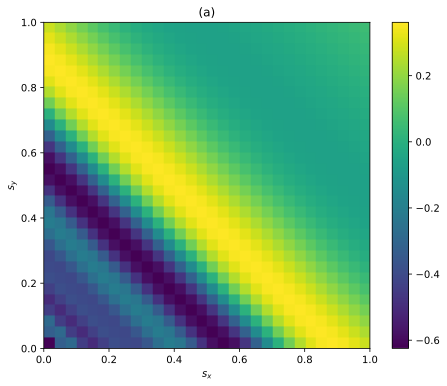

In [4]:
##Visualization
y_mat = y.reshape(n,n)
fig, ax = plt.subplots()
im = ax.imshow(y_mat , extent=[0, 1, 0, 1], origin="lower",
               vmax=y_mat .max(), vmin=y_mat .min())
plt.xlabel('$s_x$')
plt.ylabel('$s_y$')
plt.title('(a)')
plt.colorbar(im)
#plt.show()
plt.savefig("nonstat_fun_2d.pdf")

In [5]:
num_basis = [10**2,19**2,37**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

In [8]:
tf.keras.metrics.MeanAbsolutePercentageError(
    name="mean_absolute_percentage_error", dtype=None
)

def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    #sgd = optimizers.gradient_descent_v2.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results_test = model.evaluate(X_test, y_test, verbose=0)
    results_train = model.evaluate(X_train, y_train, verbose=0)
    return results_test, results_train
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch



In [8]:
# Baseline DNN only with coordinates
# Neural network
model_base = Sequential()
model_base.add(Dense(100, input_dim=2,  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_base.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(Dense(100, activation='relu'))
model_base.add(BatchNormalization())
model_base.add(Dense(1, activation='linear'))

In [12]:
# DeepKriging model for continuous data with 4 hidden layers
model_4 = Sequential()
model_4.add(Dense(100, input_dim = K,  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(1, activation='linear'))

In [15]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

In [16]:
def mse(y_pred,y_true):
    mse = np.mean((y_pred-y_true)**2)
    return mse

def mae(y_pred,y_true):
    mae = np.mean(np.absolute(y_pred-y_true))
    return mae

def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse

def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/np.absolute(y_true))
    return mape

In [18]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 123)
fold_no = 1
inputs = phi
inputs_base = s
targets = y
rmse_per_fold = []
rmse_per_fold_base = []
rmse_per_fold_gp = []
mape_per_fold = []
mape_per_fold_base = []
mape_per_fold_gp = []
rmse_per_fold_train = []
rmse_per_fold_base_train = []
rmse_per_fold_gp_train = []
mape_per_fold_train = []
mape_per_fold_base_train = []
mape_per_fold_gp_train = []
for train_idx, test_idx in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = deep_model(model, inputs[train_idx,:], targets[train_idx], inputs[test_idx,:], targets[test_idx],'continuous')
    history_base = deep_model(model_base, inputs_base[train_idx], targets[train_idx]
                              , inputs_base[test_idx], targets[test_idx],'continuous')
    model_optim = optimal_epoch(history)
    model_optim_base = optimal_epoch(history_base)
    result = test_model(model, inputs[train_idx,:], targets[train_idx], inputs[test_idx,:]
                        , targets[test_idx], model_optim)
    result_base = test_model(model_base, inputs_base[train_idx,:], targets[train_idx], inputs_base[test_idx,:]
                             , targets[test_idx], model_optim_base)
    scores = result
    scores_base = result_base
    print(f'The performance of DeepKriging: RMSE = {scores[0][1]}, MAPE = {scores[0][2]}')
    print(f'The performance of classical DNN: RMSE = {scores_base[0][1]}, MAPE = {scores_base[0][2]}')
    #ker = GPy.kern.Exponential(2,1,1)
    #ker = GPy.kern.Matern32(2,1,1)
    ker = GPy.kern.RBF(2,1,1)
    # create simple GP model
    m = GPy.models.GPRegression(s[train_idx],targets[train_idx,None],ker)
    # optimize and plot
    m.optimize(messages=True)
    z_gp_test,gp_var=m.predict(s[test_idx])
    z_gp_train,gp_train=m.predict(s[train_idx])
    scores_gp = [rmse(z_gp_test[:,0],targets[test_idx]),mape(z_gp_test[:,0],targets[test_idx])]
    scores_gp_train = [rmse(z_gp_train[:,0],targets[train_idx]),mape(z_gp_train[:,0],targets[train_idx])]
    print(f'The performance of Kriging: RMSE = {scores_gp[0]}, MAPE = {scores_gp[1]}')
    fold_no = fold_no + 1
    
    # Results for testing dataset
    rmse_per_fold.append(scores[0][1])
    rmse_per_fold_base.append(scores_base[0][1])
    rmse_per_fold_gp.append(scores_gp[0])
    mape_per_fold.append(scores[0][2])
    mape_per_fold_base.append(scores_base[0][2])
    mape_per_fold_gp.append(scores_gp[1])  
    
    # Results for training dataset
    rmse_per_fold_train.append(scores[1][1])
    rmse_per_fold_base_train.append(scores_base[1][1])
    rmse_per_fold_gp_train.append(scores_gp_train[0])
    mape_per_fold_train.append(scores[1][2])
    mape_per_fold_base_train.append(scores_base[1][2])
    mape_per_fold_gp_train.append(scores_gp_train[1]) 
    
    

------------------------------------------------------------------------
Training for fold 1 ...
The performance of DeepKriging: RMSE = 0.015182863920927048, MAPE = 14.129841804504395
The performance of classical DNN: RMSE = 0.09009981155395508, MAPE = 107.45533752441406


The performance of Kriging: RMSE = 0.0022590229688881037, MAPE = 0.0015204942694912202
------------------------------------------------------------------------
Training for fold 2 ...
The performance of DeepKriging: RMSE = 0.012868518009781837, MAPE = 19.08913230895996
The performance of classical DNN: RMSE = 0.08499427884817123, MAPE = 97.36209106445312


The performance of Kriging: RMSE = 0.000937649076766668, MAPE = 0.0005633517272098929
------------------------------------------------------------------------
Training for fold 3 ...
The performance of DeepKriging: RMSE = 0.01025392860174179, MAPE = 15.85243034362793
The performance of classical DNN: RMSE = 0.07492352277040482, MAPE = 110.93215942382812


The performance of Kriging: RMSE = 0.00015908845657608897, MAPE = 0.00034006203459354827
------------------------------------------------------------------------
Training for fold 4 ...
The performance of DeepKriging: RMSE = 0.011627016589045525, MAPE = 30.39805793762207
The performance of classical DNN: RMSE = 0.12405329197645187, MAPE = 87.06151580810547


The performance of Kriging: RMSE = 0.0004006259335018204, MAPE = 0.0005343480828716564
------------------------------------------------------------------------
Training for fold 5 ...
The performance of DeepKriging: RMSE = 0.009795633144676685, MAPE = 6.799107074737549
The performance of classical DNN: RMSE = 0.0845683366060257, MAPE = 86.14839935302734


The performance of Kriging: RMSE = 0.028667754200233826, MAPE = 0.0044966138626474795
------------------------------------------------------------------------
Training for fold 6 ...
The performance of DeepKriging: RMSE = 0.010346001945436, MAPE = 14.061626434326172
The performance of classical DNN: RMSE = 0.09107815474271774, MAPE = 103.12870025634766


The performance of Kriging: RMSE = 0.0005952956117963748, MAPE = 0.0007265186330709909
------------------------------------------------------------------------
Training for fold 7 ...
The performance of DeepKriging: RMSE = 0.011311724781990051, MAPE = 14.147786140441895
The performance of classical DNN: RMSE = 0.0860820859670639, MAPE = 92.70978546142578


The performance of Kriging: RMSE = 0.007208232217143831, MAPE = 0.004092703005225942
------------------------------------------------------------------------
Training for fold 8 ...
The performance of DeepKriging: RMSE = 0.009920735843479633, MAPE = 14.287598609924316
The performance of classical DNN: RMSE = 0.0837610512971878, MAPE = 108.94330596923828


The performance of Kriging: RMSE = 0.00030428814725347764, MAPE = 0.0002372360942038517
------------------------------------------------------------------------
Training for fold 9 ...
The performance of DeepKriging: RMSE = 0.008822117000818253, MAPE = 12.358732223510742
The performance of classical DNN: RMSE = 0.08469869941473007, MAPE = 84.0858383178711


The performance of Kriging: RMSE = 0.0019207453483182885, MAPE = 0.001159860388648323
------------------------------------------------------------------------
Training for fold 10 ...
The performance of DeepKriging: RMSE = 0.005267356988042593, MAPE = 6.057576656341553
The performance of classical DNN: RMSE = 0.07628795504570007, MAPE = 92.60266876220703


The performance of Kriging: RMSE = 0.0018706145322306092, MAPE = 0.0014040905986145407


In [ ]:
import matplotlib as mpl
mpl.style.use("seaborn")
data= [rmse_per_fold,rmse_per_fold_base,rmse_per_fold_gp]
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_subplot(111) 
  
# Creating axes instance 
bp = ax.boxplot(data, patch_artist = True, 
                notch ='True', vert = 0) 
  
colors = ['#0000FF', '#00FF00',  
          '#FFFF00'] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
  
# changing color and linewidth of 
# whiskers 
for whisker in bp['whiskers']: 
    whisker.set(color ='black', 
                linewidth = 1.5, 
                linestyle =":") 
  
# changing color and linewidth of 
# caps 
for cap in bp['caps']: 
    cap.set(color ='#8B008B', 
            linewidth = 2) 
  
# changing color and linewidth of 
# medians 
for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3) 
  
# changing style of fliers 
for flier in bp['fliers']: 
    flier.set(marker ='D', 
              color ='#e7298a', 
              alpha = 0.5) 
      
# x-axis labels 
ax.set_yticklabels(['DeepKriging', 'Baseline DNN',  
                    'Kriging']) 
  
# Adding title  
plt.title("(b)") 
plt.xlabel('Root Mean Squared Error based on 10-fold cross validation')
#plt.xlim((0,0.02)) 
# Removing top axes and right axes 
# ticks 
ax.get_xaxis().tick_bottom() 
ax.get_yaxis().tick_left() 
      
# show plot 
#plt.show(bp) 
plt.savefig("boxplot_new.pdf")

In [20]:
# Print results for the testing set
print(np.mean(rmse_per_fold))
print(np.std(rmse_per_fold))
print(np.mean(rmse_per_fold_base))
print(np.std(rmse_per_fold_base))
print(np.mean(rmse_per_fold_gp))
print(np.std(rmse_per_fold_gp))
print(np.mean(mape_per_fold))
print(np.std(mape_per_fold))
print(np.mean(mape_per_fold_base))
print(np.std(mape_per_fold_base))
print(np.mean(mape_per_fold_gp))
print(np.std(mape_per_fold_gp))

0.010539589682593942
0.002460980954048004
0.08805471882224084
0.012943016491387628
0.004432331649270907
0.008313523407641348
14.718188953399657
6.4095478315893715
97.0429801940918
9.51201371752292
0.0015075278696577445
0.0014551510647627934


In [21]:
# Print results for the training set

print(np.mean(rmse_per_fold_train))
print(np.std(rmse_per_fold_train))
print(np.mean(rmse_per_fold_base_train))
print(np.std(rmse_per_fold_base_train))
print(np.mean(rmse_per_fold_gp_train))
print(np.std(rmse_per_fold_gp_train))
print(np.mean(mape_per_fold_train))
print(np.std(mape_per_fold_train))
print(np.mean(mape_per_fold_base_train))
print(np.std(mape_per_fold_base_train))
print(np.mean(mape_per_fold_gp_train))
print(np.std(mape_per_fold_gp_train))

0.010675040073692799
0.002311269814538169
0.08782033324241638
0.0073355055779713
3.2349213394679624e-05
4.065972743346282e-06
14.263153171539306
3.6769348184127657
94.93298263549805
5.737350444260662
5.428707775092566e-05
1.3134156288456762e-05
